# SENTIMENT ANALYSIS AND OPINION MINING PROJECT
## PUBLIC OPINION ON NEWS

https://island.ricerca.di.unimi.it/~alfio/shared/textsent/2020-21/projects.html

The New York Times Comments dataset (https://www.kaggle.com/aashita/nyt-comments?select=CommentsApril2017.csv) contains articles published on the New York Times and the comments they received from readers. <br>
The task of the project is to analyze, using the variables *editorsSelection*, *recommendations*, and *replyCount* as targets, the rate of success of a comment. This rate of success should be intepreted as a measure of how much controversial was the commented article. On this base, the project aims at studing which topics (indicated by the features sectionName and/or newDesk) were mostly controversial. Optionally, the project could also determine if a comment opinion is against or if favor of the article.

In [97]:
import pandas as pd
import numpy as np
import os

In [98]:
import seaborn as sns
import matplotlib.pylab as plt
import pickle
from tqdm.auto import tqdm
import time
import itertools
import functools
import operator
import time
from collections import defaultdict
import os
#from google.colab import drive, files

from glob import glob
import os
import json
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread

import torch
import torch.nn.functional as F
#import torchvision
#import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

# 4. UNSUPERVISED SENTIMENT POLARITY LABELLING OF COMMENTS 

New labels are created in an unsupervised way, so by using a lexicon-based method. Two libraries (TextBlob and Vader) are used to retrieve the polarity and intensity of comments, with a score from -1 to +1. <br>
Two summary variables are created from the original 3 targets:
- Binary summary variable: it takes value 1 if there is at least a positive label or else 0 
- Multiclass summary variable: it takes value equal to the number of positive labels

In order to understand whether the new unsupervised labels are a good alternative to the ground truth, two methods are used:
- Point biserial correlation (between continuous and binary features)
- AUPRC of a 10-folds cross validation with a logistic regression

Finally, the topics are graphically studied based on their sentiment polarity.

In [3]:
# read the dataset and select only the columns needed

def load_comments():
    X=pd.read_csv('data/dataset_cleansed_version.csv')
    X = X[['commentBody','editorsSelection_TARGET','recommendations_TARGET','replyCount_TARGET']]

    # create the summary multiclass variable, which takes value equal to the number of positive labels
    X['Summary_TARGET_multiclass'] = X[['editorsSelection_TARGET',
                         'recommendations_TARGET','replyCount_TARGET']].sum(axis=1)
    # create the summary binary variable which takes value 1 if there is at least a positive label or else 0 
    X['Summary_TARGET_binary'] = X[['editorsSelection_TARGET',
                         'recommendations_TARGET','replyCount_TARGET']].sum(axis=1).apply(lambda x: 1 if x>=1 else 0)
    
    return X

In [4]:
from scipy.stats import pointbiserialr

def point_biserial_corr(X,Y):
    """Calculate a point biserial correlation coefficient and the associated p-value for each 
    combination of dependent and independent variables passed
    
    Parameters
    ------------
    X: data
    Y: labels
    """
    
    for x_col, y_col in itertools.product(X.columns, Y.columns):   
        x = X[x_col]
        y = Y[y_col]
        corr = pointbiserialr(x,y)
        
        print('y: {}, X: {}'.format(y_col,x_col))
        print('pointbiserialr correlation: %.4f' % (corr[0]))
        print('pointbiserialr pvalue: %.4f \n' % (corr[1]))
        

In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score # AUPRC (area under the precision recall curve)


def logistic_for_significance(X, Y):
    """perform a logistic regression between a single dependent and independent variable 
    and retrieve the AUPRC of a 10-folds cross validation
    
    Parameters
    ------------
    X: data
    Y: labels
    """
    
    # consider all the possible combinations of x and y
    for x_col, y_col in itertools.product(X.columns, Y.columns):
            
        x = X[x_col].values.reshape(-1, 1)
        y = Y[y_col].values
        
        # perform 10-folds cv with logistic regression
        cv = KFold(n_splits=10, random_state=123, shuffle=True)
        model = LogisticRegression()
        
        if y_col == 'Summary_TARGET_binary':
            # the baseline is the score when the classifier guesses at random
            baseline_binary_pos = Y[y_col][Y[y_col]==1].count() / Y[y_col].count()
            
            # compute the AUPRC for the positive score
            AUPRC = make_scorer(average_precision_score, average='weighted')
            scores = cross_val_score(model, x, y, scoring=AUPRC, cv=cv, n_jobs=-1, error_score="raise")
            
            print('y: {}, X: {}'.format(y_col,x_col))
            print('AUPRC: %.4f' % (scores.mean()))
            print('Baseline positive class: %.4f \n' % (baseline_binary_pos))
        
        elif y_col == 'Summary_TARGET_multiclass':
            
            class_scores = []
            class_baseline = []
            # compute the AUPRC for each class with a one vs rest approach
            for class_ in range(1,4):
                # set to 0 all the classes which are not the class considered
                y_binarized =  Y[y_col].apply(lambda x: 0 if x != class_ else x)
                AUPRC = make_scorer(average_precision_score, average='weighted', pos_label=class_)
                scores = cross_val_score(model, x, y_binarized.values, scoring=AUPRC, cv=cv, n_jobs=-1, error_score="raise")
                
                # store the AUPRC for each class and its baseline
                class_scores.append(np.round(scores.mean(),4))
                class_baseline.append( np.round(y_binarized[y_binarized == class_].count() / y_binarized.count(),4) )
            
            print('y: {}, X: {}'.format(y_col,x_col))
            print('AUPRC: {}'.format(class_scores))
            print('Baseline positive class: {} \n'.format(class_baseline))

# 1) TEXTBLOB

In [ ]:
pip install textblob

In [ ]:
from textblob import TextBlob

# functions to retrieve the sentiment of text

def get_sentiment_absolute(x):
  
  comment = TextBlob(str(x))
  polarity = comment.sentiment.polarity
  return 1 if polarity >=0.01 else -1 if polarity <=-0.01 else 0

def get_sentiment(x):
  
  comment = TextBlob(str(x))
  polarity = comment.sentiment.polarity
  return polarity

def get_sentiment_subjectivity(x):
    comment = TextBlob(str(x))
    polarity = comment.sentiment.polarity
    subj = comment.sentiment.subjectivity
    # use the subjectivity to weight the polarity
    return polarity*subj

In [ ]:
X = load_comments()

In [ ]:
X.to_csv('data/dataset_sentiment_textblob.csv')

In [78]:
# create the unsupervised labels

X['sentiment'] = X['commentBody'].apply(get_sentiment)
X['sentiment_absolute'] = X['commentBody'].apply(get_sentiment_absolute)
X['sentiment_subjectivity'] = X['commentBody'].apply(get_sentiment_subjectivity)

In [12]:
# show some statistics for the multiclass summary variable

X.groupby('Summary_TARGET_multiclass').agg([np.mean,np.median,np.std])[['sentiment','sentiment_absolute','sentiment_subjectivity']]

sentiment                     sentiment_absolute  \
                               mean    median       std               mean   
Summary_TARGET_multiclass                                                    
0                          0.059542  0.000000  0.247310           0.225199   
1                          0.057028  0.018466  0.246909           0.229923   
2                          0.055373  0.034902  0.227292           0.255949   
3                          0.056684  0.050000  0.196286           0.293618   

                                           sentiment_subjectivity            \
                          median       std                   mean    median   
Summary_TARGET_multiclass                                                     
0                              0  0.832348               0.032105  0.000000   
1                              1  0.860119               0.029672  0.006059   
2                              1  0.875663               0.027097  0.012397   
3                              1  0.901962               0.027767  0.019711   

                                     
                                std  
Summary_TARGET_multiclass            
0                          0.180272  
1                          0.179243  
2                          0.159428  
3                          0.128249

In [13]:
# show some statistics for the binary summary variable

X.groupby('Summary_TARGET_binary').agg([np.mean,np.median,np.std])[['sentiment','sentiment_absolute','sentiment_subjectivity']] 

sentiment                  sentiment_absolute         \
                           mean median       std               mean median   
Summary_TARGET_binary                                                        
0                      0.059542  0.000  0.247310           0.225199      0   
1                      0.056618  0.025  0.241215           0.237721      1   

                                sentiment_subjectivity                      
                            std                   mean    median       std  
Summary_TARGET_binary                                                       
0                      0.832348               0.032105  0.000000  0.180272  
1                      0.865024               0.029004  0.008281  0.173597

### VISUAL EXPLORATION

<AxesSubplot:xlabel='Summary_TARGET_multiclass', ylabel='sentiment_subjectivity'>

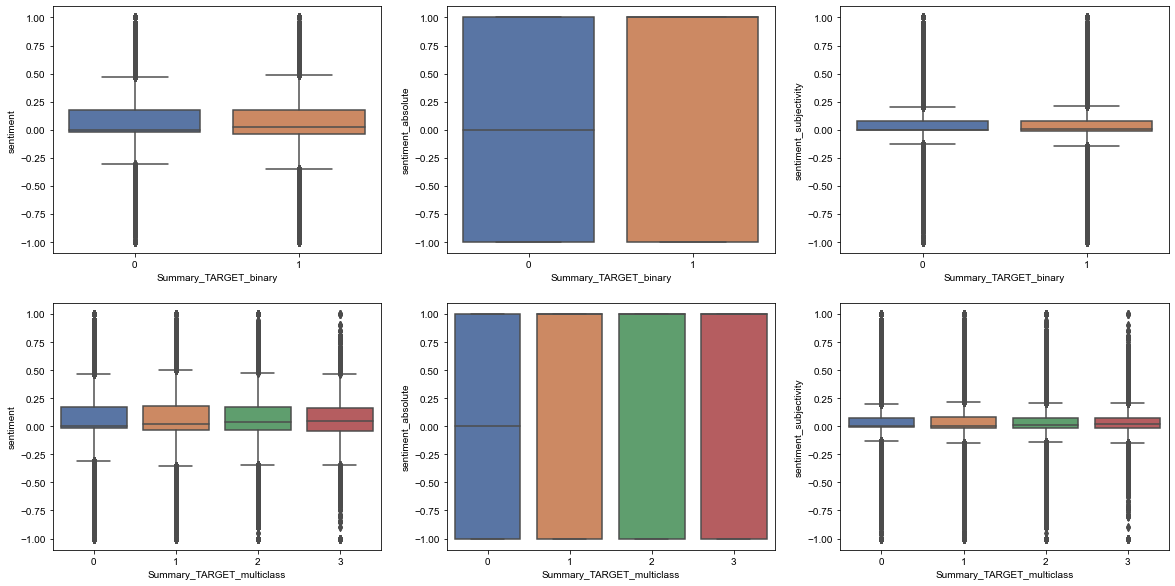

In [14]:
# BOXPLOT of the sentiment labels wrt each class of the ground truth

fig, axes = plt.subplots(2,3, figsize=(20, 10))
sns.set_theme(style="darkgrid")

sns.boxplot(ax=axes[0,0], x="Summary_TARGET_binary", y="sentiment", data=X) 
sns.boxplot(ax=axes[0,1], x="Summary_TARGET_binary", y="sentiment_absolute", data=X)
sns.boxplot(ax=axes[0,2], x="Summary_TARGET_binary", y="sentiment_subjectivity", data=X)

sns.boxplot(ax=axes[1,0], x="Summary_TARGET_multiclass", y="sentiment", data=X) 
sns.boxplot(ax=axes[1,1], x="Summary_TARGET_multiclass", y="sentiment_absolute", data=X)
sns.boxplot(ax=axes[1,2], x="Summary_TARGET_multiclass", y="sentiment_subjectivity", data=X)

<AxesSubplot:xlabel='sentiment_subjectivity', ylabel='Density'>

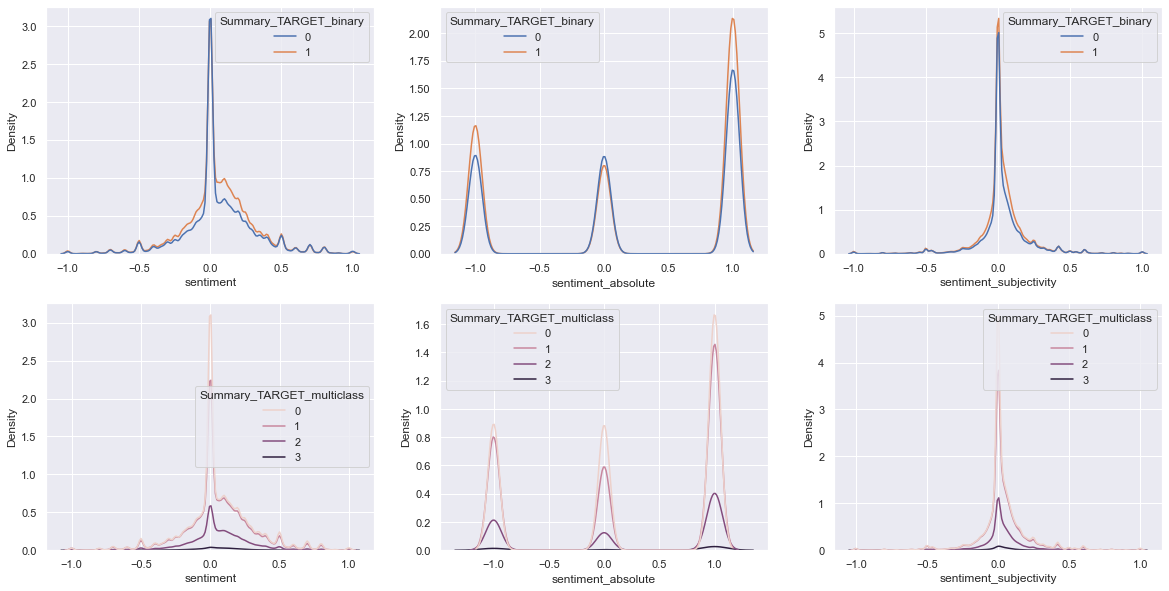

In [20]:
# DENSITY DISTRIBUTION of the sentiment labels wrt each class of the ground truth

fig, axes = plt.subplots(2,3, figsize=(20, 10))
sns.set_theme(style="darkgrid")

sns.kdeplot(ax=axes[0,0], x="sentiment", hue="Summary_TARGET_binary", data=X)
sns.kdeplot(ax=axes[0,1], x="sentiment_absolute", hue="Summary_TARGET_binary", data=X)
sns.kdeplot(ax=axes[0,2], x="sentiment_subjectivity", hue="Summary_TARGET_binary", data=X)

sns.kdeplot(ax=axes[1,0], x="sentiment", hue="Summary_TARGET_multiclass", data=X)
sns.kdeplot(ax=axes[1,1], x="sentiment_absolute", hue="Summary_TARGET_multiclass", data=X)
sns.kdeplot(ax=axes[1,2], x="sentiment_subjectivity", hue="Summary_TARGET_multiclass", data=X)

### RELATIONSHIP BETWEEN THE UNSUPERVISED LABELS AND THE CONTROVERSY OF COMMENTS

In [21]:
point_biserial_corr(X[['sentiment','sentiment_absolute','sentiment_subjectivity']], 
                          X[['Summary_TARGET_binary']])

y: Summary_TARGET_binary, X: sentiment
pointbiserialr correlation: -0.0060
pointbiserialr pvalue: 0.0000 

y: Summary_TARGET_binary, X: sentiment_absolute
pointbiserialr correlation: 0.0073
pointbiserialr pvalue: 0.0000 

y: Summary_TARGET_binary, X: sentiment_subjectivity
pointbiserialr correlation: -0.0087
pointbiserialr pvalue: 0.0000 



In [25]:
logistic_for_significance(X[['sentiment','sentiment_absolute','sentiment_subjectivity']], 
                          X[['Summary_TARGET_binary','Summary_TARGET_multiclass']])

y: Summary_TARGET_binary, X: sentiment
AUPRC: 0.5442
Baseline positive class: 0.5442 

y: Summary_TARGET_multiclass, X: sentiment
AUPRC: [0.3996, 0.1319, 0.0127]
Baseline positive class: [0.3996, 0.1319, 0.0127] 

y: Summary_TARGET_binary, X: sentiment_absolute
AUPRC: 0.5442
Baseline positive class: 0.5442 

y: Summary_TARGET_multiclass, X: sentiment_absolute
AUPRC: [0.3996, 0.1319, 0.0127]
Baseline positive class: [0.3996, 0.1319, 0.0127] 

y: Summary_TARGET_binary, X: sentiment_subjectivity
AUPRC: 0.5442
Baseline positive class: 0.5442 

y: Summary_TARGET_multiclass, X: sentiment_subjectivity
AUPRC: [0.3996, 0.1319, 0.0127]
Baseline positive class: [0.3996, 0.1319, 0.0127] 



# 2) VADER

In [26]:
#X=pd.read_csv('data/dataset_sentiment_vader.csv')

In [6]:
X = load_comments()

In [7]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# functions to get the sentiment labels 

def get_sentiment_compound(x):
    polarity = sid.polarity_scores(str(x))
    return polarity['compound']

def get_sentiment_absolute(x):
    polarity = sid.polarity_scores(str(x))
    polarity = polarity['compound']
    return 1 if polarity >0 else -1 if polarity < 0 else 0

def get_sentiment(x):
    polarity = sid.polarity_scores(str(x))
    del polarity['compound']
    max_pol = max(polarity.items(), key=operator.itemgetter(1))
    return max_pol[1] if max_pol[0] == 'pos' else - max_pol[1] if max_pol[0] == 'neg' else 0    
# we can also return 0 if max is neutral, or return the number itself if pos 
#is max or - the number if max is neg

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Niki/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
X['sentiment'] = X['commentBody'].apply(get_sentiment)
X['sentiment_absolute'] = X['commentBody'].apply(get_sentiment_absolute)
X['sentiment_compound'] = X['commentBody'].apply(get_sentiment_compound)

In [9]:
X.to_csv('data/dataset_sentiment_vader.csv')

In [10]:
# show some statistics for the multiclass summary variable

X.groupby('Summary_TARGET_binary').agg([np.mean,np.median,np.std])[['sentiment','sentiment_absolute','sentiment_compound']] 

sentiment                  sentiment_absolute         \
                           mean median       std               mean median   
Summary_TARGET_binary                                                        
0                      0.007251    0.0  0.228847           0.091594      0   
1                      0.001393    0.0  0.206496           0.077048      0   

                                sentiment_compound                   
                            std               mean median       std  
Summary_TARGET_binary                                                
0                      0.895943           0.055847    0.0  0.549695  
1                      0.932774           0.050227    0.0  0.594765

In [11]:
# show some statistics for the binary summary variable

X.groupby('Summary_TARGET_multiclass').agg([np.mean,np.median,np.std])[['sentiment','sentiment_absolute','sentiment_compound']] 

sentiment                  sentiment_absolute  \
                               mean median       std               mean   
Summary_TARGET_multiclass                                                 
0                          0.007251    0.0  0.228847           0.091594   
1                          0.002644    0.0  0.215441           0.076772   
2                         -0.002320    0.0  0.182486           0.075638   
3                          0.000593    0.0  0.144066           0.100282   

                                           sentiment_compound                   
                          median       std               mean median       std  
Summary_TARGET_multiclass                                                       
0                              0  0.895943           0.055847  0.000  0.549695  
1                              0  0.927029           0.049348  0.000  0.585064  
2                              0  0.946082           0.050575  0.000  0.615725  
3                              1  0.972513           0.074175  0.128  0.670419

### VISUAL EXPLORATION

<AxesSubplot:xlabel='Summary_TARGET_multiclass', ylabel='sentiment_compound'>

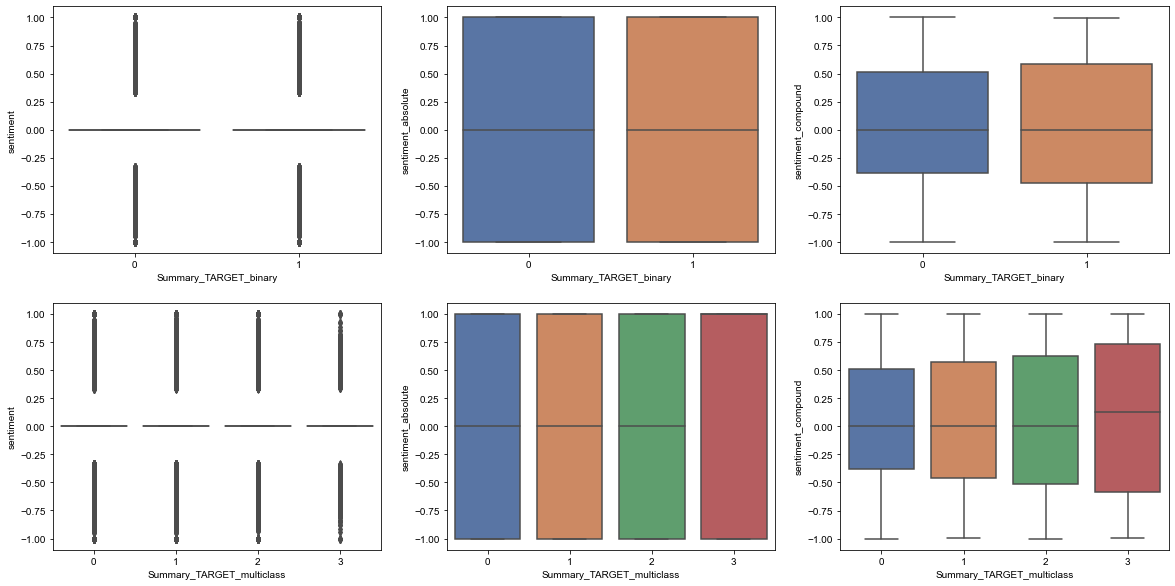

In [12]:
# BOXPLOT of the sentiment labels wrt each class of the ground truth

fig, axes = plt.subplots(2,3, figsize=(20, 10))
sns.set_theme(style="darkgrid")

sns.boxplot(ax=axes[0,0], x="Summary_TARGET_binary", y="sentiment", data=X) 
sns.boxplot(ax=axes[0,1], x="Summary_TARGET_binary", y="sentiment_absolute", data=X)
sns.boxplot(ax=axes[0,2], x="Summary_TARGET_binary", y="sentiment_compound", data=X)

sns.boxplot(ax=axes[1,0], x="Summary_TARGET_multiclass", y="sentiment", data=X) 
sns.boxplot(ax=axes[1,1], x="Summary_TARGET_multiclass", y="sentiment_absolute", data=X)
sns.boxplot(ax=axes[1,2], x="Summary_TARGET_multiclass", y="sentiment_compound", data=X)

<AxesSubplot:xlabel='sentiment_compound', ylabel='Density'>

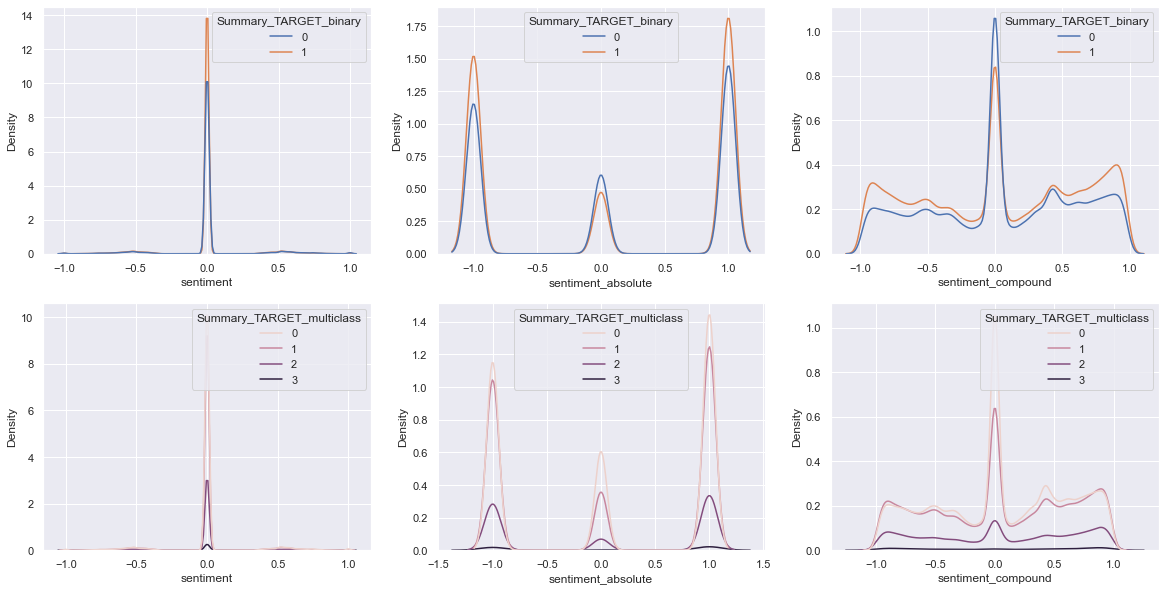

In [13]:
# DENSITY DISTRIBUTION of the sentiment labels wrt each class of the ground truth

fig, axes = plt.subplots(2,3, figsize=(20, 10))
sns.set_theme(style="darkgrid")

sns.kdeplot(ax=axes[0,0], x="sentiment", hue="Summary_TARGET_binary", data=X)
sns.kdeplot(ax=axes[0,1], x="sentiment_absolute", hue="Summary_TARGET_binary", data=X)
sns.kdeplot(ax=axes[0,2], x="sentiment_compound", hue="Summary_TARGET_binary", data=X)

sns.kdeplot(ax=axes[1,0], x="sentiment", hue="Summary_TARGET_multiclass", data=X)
sns.kdeplot(ax=axes[1,1], x="sentiment_absolute", hue="Summary_TARGET_multiclass", data=X)
sns.kdeplot(ax=axes[1,2], x="sentiment_compound", hue="Summary_TARGET_multiclass", data=X)

### RELATIONSHIP BETWEEN THE UNSUPERVISED LABELS AND THE CONTROVERSY OF COMMENTS

In [14]:
point_biserial_corr(X[['sentiment','sentiment_absolute','sentiment_compound']], 
                          X[['Summary_TARGET_binary']])

y: Summary_TARGET_binary, X: sentiment
pointbiserialr correlation: -0.0134
pointbiserialr pvalue: 0.0000 

y: Summary_TARGET_binary, X: sentiment_absolute
pointbiserialr correlation: -0.0079
pointbiserialr pvalue: 0.0000 

y: Summary_TARGET_binary, X: sentiment_compound
pointbiserialr correlation: -0.0049
pointbiserialr pvalue: 0.0000 



In [15]:
logistic_for_significance(X[['sentiment','sentiment_absolute','sentiment_compound']], 
                          X[['Summary_TARGET_binary','Summary_TARGET_multiclass']])

y: Summary_TARGET_binary, X: sentiment
AUPRC: 0.5442
Baseline positive class: 0.5442 

y: Summary_TARGET_multiclass, X: sentiment
AUPRC: [0.3996, 0.1319, 0.0127]
Baseline positive class: [0.3996, 0.1319, 0.0127] 

y: Summary_TARGET_binary, X: sentiment_absolute
AUPRC: 0.5442
Baseline positive class: 0.5442 

y: Summary_TARGET_multiclass, X: sentiment_absolute
AUPRC: [0.3996, 0.1319, 0.0127]
Baseline positive class: [0.3996, 0.1319, 0.0127] 

y: Summary_TARGET_binary, X: sentiment_compound
AUPRC: 0.5442
Baseline positive class: 0.5442 

y: Summary_TARGET_multiclass, X: sentiment_compound
AUPRC: [0.3996, 0.1319, 0.0127]
Baseline positive class: [0.3996, 0.1319, 0.0127] 



# SENTIMENT POLARITY OF TOPICS 

# 1) TEXTBLOB

In [100]:
X = pd.merge(pd.read_csv('data/dataset_sentiment_textblob.csv'), pd.read_csv('data/dataset_cleansed_version.csv', usecols=['sectionName_x','newDesk_x']), left_index=True, right_index=True)

In [104]:
def show_polarity(X, topics_variable):
    """Plot the barplots of the polarity of topics.
    
    Parameters
    ---------------
    X: data
    topics_variable: variable of topics to use among 'sectionName_x', 'newDesk_x'.
    """
    
    if topics_variable not in ['sectionName_x', 'newDesk_x']:
        raise ValueError(
            "Argument 'topics_variable' has an incorrect value: use 'sectionName_x', 'newDesk_x'")
    

    # count the different labels for each topic
    freq_X = pd.DataFrame(X.groupby([topics_variable,'sentiment_absolute']).count().iloc[:,0])
    freq_X.columns = ['count']
    # retrieve percentage of labels for each topic
    freq_X = freq_X / freq_X.groupby(topics_variable).sum()
    freq_X.reset_index(level=[0,1], inplace=True)
    
    # order the topics by the percentage of controversial comments
    ordered_freq_pos = freq_X[freq_X['sentiment_absolute']==1].sort_values(by='count', ascending=False)[topics_variable]
    ordered_freq_neg = freq_X[freq_X['sentiment_absolute']==-1].sort_values(by='count', ascending=False)[topics_variable]
    
    fig, ax = plt.subplots(1,2, figsize=(20, 7))
    sns.set_theme(style="darkgrid")
    plt.suptitle('Percentage barplot of the polarity of {}'.format(topics_variable),fontsize=25)
    
    sns.barplot(ax=ax[0], x=topics_variable,y='count',hue='sentiment_absolute', data=freq_X, 
                     palette=["#e03453", "#faf252", "#5de38d"], order=ordered_freq_pos[:5])
    sns.barplot(ax=ax[1], x=topics_variable,y='count',hue='sentiment_absolute', data=freq_X, 
                     palette=["#e03453", "#faf252", "#5de38d"], order=ordered_freq_neg[:5])

    ax[0].set_title('by positive', fontsize=20)
    ax[1].set_title('by negative',fontsize=20)
    for i in [0,1]:
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        ax[i].set_ylim(0,1)
        ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=15,rotation=45, horizontalalignment='right')
        ax[i].tick_params(axis="y", labelsize=15)

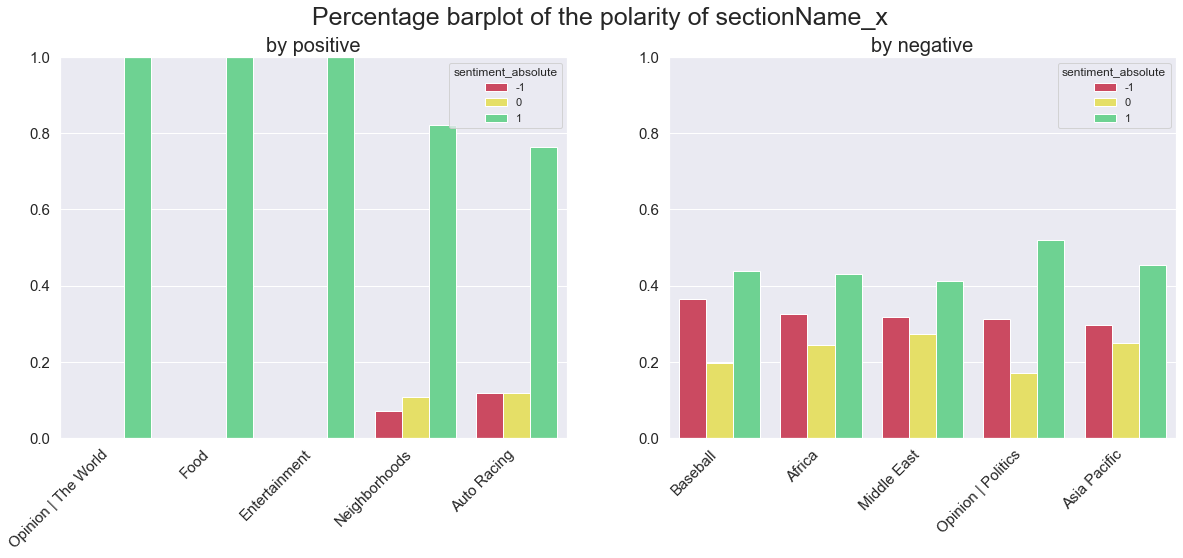

In [105]:
show_polarity(X, topics_variable='sectionName_x')

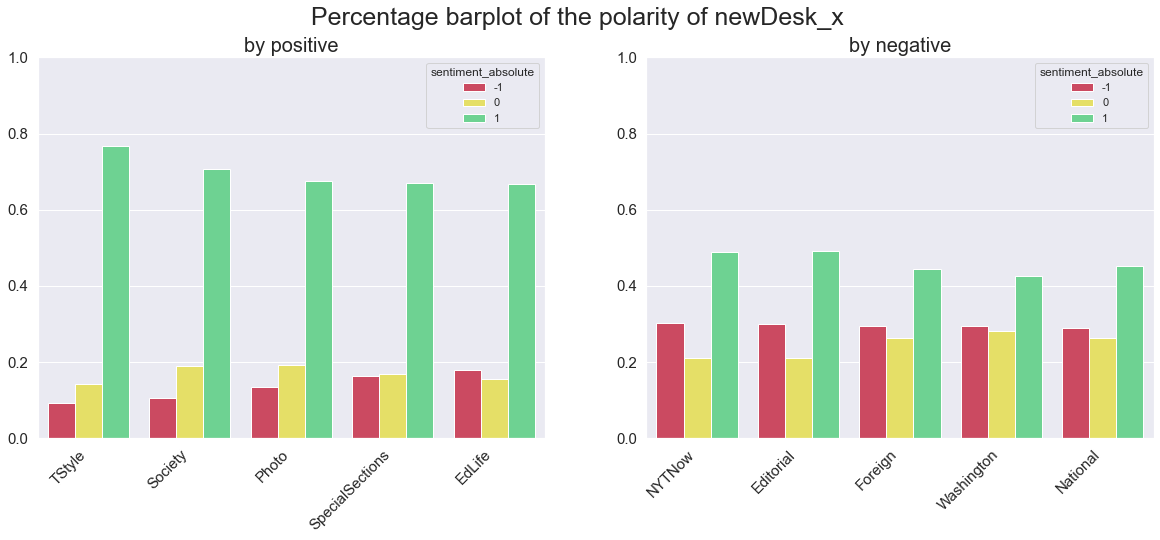

In [106]:
show_polarity(X, topics_variable='newDesk_x')

# 2) VADER

In [90]:
X = pd.merge(pd.read_csv('data/dataset_sentiment_vader.csv'), pd.read_csv('data/dataset_cleansed_version.csv', usecols=['sectionName_x','newDesk_x']), left_index=True, right_index=True)

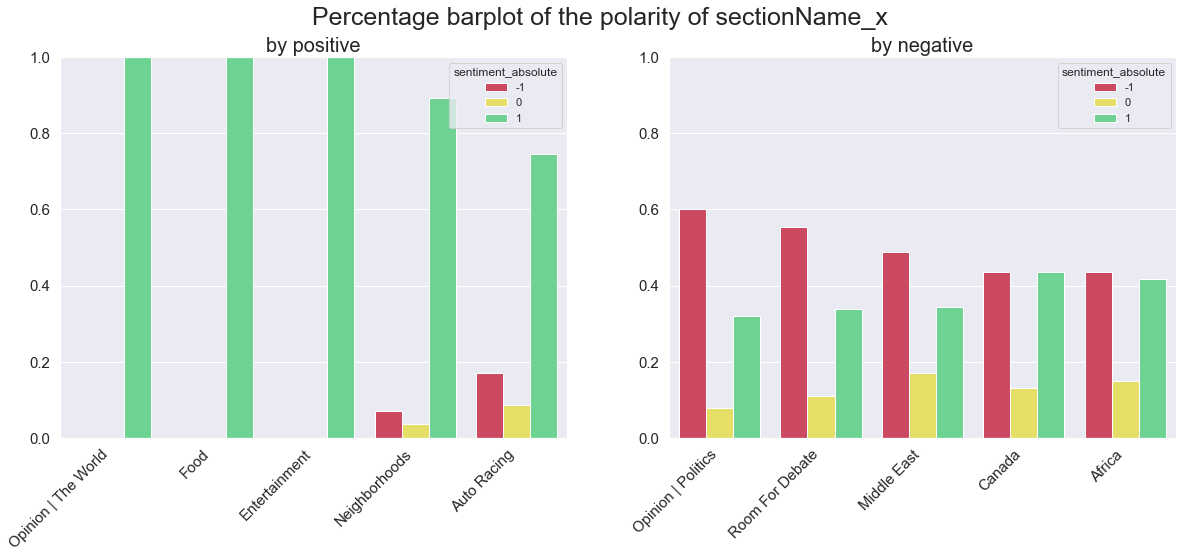

In [91]:
show_polarity(X, topics_variable='sectionName_x')

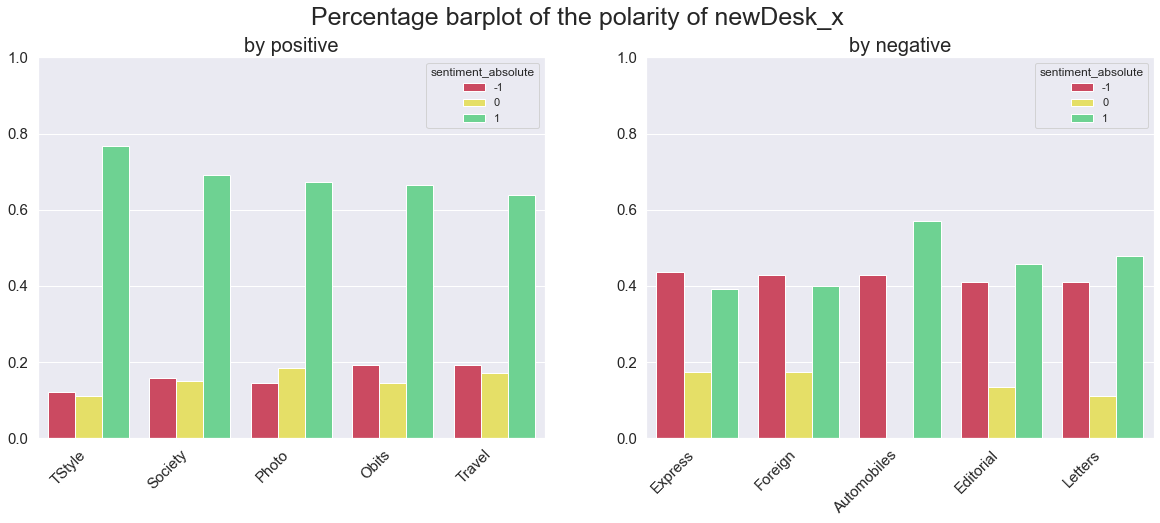

In [92]:
show_polarity(X, topics_variable='newDesk_x')